# Credit Card Lead Prediction

Link: https://datahack.analyticsvidhya.com/contest/job-a-thon-2/?utm_source=Blog&utm_medium=Navbar&utm_campaign=Jobathon#About

Happy Customer Bank is a mid-sized private bank that deals in all kinds of banking products, like Savings accounts, Current accounts, investment products, credit products, among other offerings.



The bank also cross-sells products to its existing customers and to do so they use different kinds of communication like tele-calling, e-mails, recommendations on net banking, mobile banking, etc. 



In this case, the Happy Customer Bank wants to cross sell its credit cards to its existing customers. The bank has identified a set of customers that are eligible for taking these credit cards.



Now, the bank is looking for your help in identifying customers that could show higher intent towards a recommended credit card, given:

Customer details (gender, age, region etc.)
Details of his/her relationship with the bank (Channel_Code,Vintage, 'Avg_Asset_Value etc.)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%pylab inline
plt.rcParams['figure.figsize'] = 10,8
plt.rcParams['axes.grid'] = True
plt.gray()

Populating the interactive namespace from numpy and matplotlib


<Figure size 720x576 with 0 Axes>

In [2]:
import statsmodels.formula.api as sms
import scipy.stats as stats

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices


In [3]:
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, roc_auc_score, roc_curve

import random
import os
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe, pyll
import time
import colorama  # https://pypi.python.org/pypi/colorama
import pickle
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
from catboost import CatBoostClassifier, Pool

import warnings
warnings.filterwarnings('ignore')

In [4]:
#Load the files
train = pd.read_csv("train_s3TEQDk.csv")
test = pd.read_csv("test_mSzZ8RL.csv")
sample_submission =pd.read_csv("sample_submission_eyYijxG.csv")

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245725 entries, 0 to 245724
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ID                   245725 non-null  object
 1   Gender               245725 non-null  object
 2   Age                  245725 non-null  int64 
 3   Region_Code          245725 non-null  object
 4   Occupation           245725 non-null  object
 5   Channel_Code         245725 non-null  object
 6   Vintage              245725 non-null  int64 
 7   Credit_Product       216400 non-null  object
 8   Avg_Account_Balance  245725 non-null  int64 
 9   Is_Active            245725 non-null  object
 10  Is_Lead              245725 non-null  int64 
dtypes: int64(4), object(7)
memory usage: 20.6+ MB


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105312 entries, 0 to 105311
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ID                   105312 non-null  object
 1   Gender               105312 non-null  object
 2   Age                  105312 non-null  int64 
 3   Region_Code          105312 non-null  object
 4   Occupation           105312 non-null  object
 5   Channel_Code         105312 non-null  object
 6   Vintage              105312 non-null  int64 
 7   Credit_Product       92790 non-null   object
 8   Avg_Account_Balance  105312 non-null  int64 
 9   Is_Active            105312 non-null  object
dtypes: int64(3), object(7)
memory usage: 8.0+ MB


In [7]:
train.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,NNVBBKZB,Female,73,RG268,Other,X3,43,No,1045696,No,0
1,IDD62UNG,Female,30,RG277,Salaried,X1,32,No,581988,No,0
2,HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0
3,BF3NC7KV,Male,34,RG270,Salaried,X1,19,No,470454,No,0
4,TEASRWXV,Female,30,RG282,Salaried,X1,33,No,886787,No,0


In [8]:
test.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active
0,VBENBARO,Male,29,RG254,Other,X1,25,Yes,742366,No
1,CCMEWNKY,Male,43,RG268,Other,X2,49,NaN,925537,No
2,VK3KGA9M,Male,31,RG270,Salaried,X1,14,No,215949,No
3,TT8RPZVC,Male,29,RG272,Other,X1,33,No,868070,No
4,SHQZEYTZ,Female,29,RG270,Other,X1,19,No,657087,No


In [9]:
train.shape, test.shape

((245725, 11), (105312, 10))

# Check for Duplicate Rows from Train Data

In [10]:
#check for duplicate entries and remove those
train.drop_duplicates(inplace = True)

In [11]:
train.shape

(245725, 11)

# Impute Missing Values

In [12]:
# Train Data
train.isnull().sum() / len(train) * 100

ID                      0.000000
Gender                  0.000000
Age                     0.000000
Region_Code             0.000000
Occupation              0.000000
Channel_Code            0.000000
Vintage                 0.000000
Credit_Product         11.934073
Avg_Account_Balance     0.000000
Is_Active               0.000000
Is_Lead                 0.000000
dtype: float64

In [13]:
train['Credit_Product'].value_counts()

No     144357
Yes     72043
Name: Credit_Product, dtype: int64

In [14]:
train['Credit_Product'].isnull().sum()

29325

In [15]:
# Test Data
test.isnull().sum() / len(test) * 100

ID                      0.000000
Gender                  0.000000
Age                     0.000000
Region_Code             0.000000
Occupation              0.000000
Channel_Code            0.000000
Vintage                 0.000000
Credit_Product         11.890383
Avg_Account_Balance     0.000000
Is_Active               0.000000
dtype: float64

In [16]:
test['Credit_Product'].isnull().sum()

12522

In [17]:
test['Credit_Product'].value_counts()

No     61608
Yes    31182
Name: Credit_Product, dtype: int64

In [18]:
train = train.fillna('Yes')
test = test.fillna('Yes')

In [19]:
train.isnull().values.any(), test.isnull().values.any()

(False, False)

# Exploratory Data Analysis

In [20]:
for col in train.select_dtypes('object').columns:
    print(col, train[col].nunique())

ID 245725
Gender 2
Region_Code 35
Occupation 4
Channel_Code 4
Credit_Product 2
Is_Active 2


In [21]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,245725.0,4.385631e+01,14.828672,23.0,30.0,43.0,54.0,85.0
Vintage,245725.0,4.695914e+01,32.353136,7.0,20.0,32.0,73.0,135.0
Avg_Account_Balance,245725.0,1.128403e+06,852936.356069,20790.0,604310.0,894601.0,1366666.0,10352009.0
Is_Lead,245725.0,2.372083e-01,0.425372,0.0,0.0,0.0,0.0,1.0


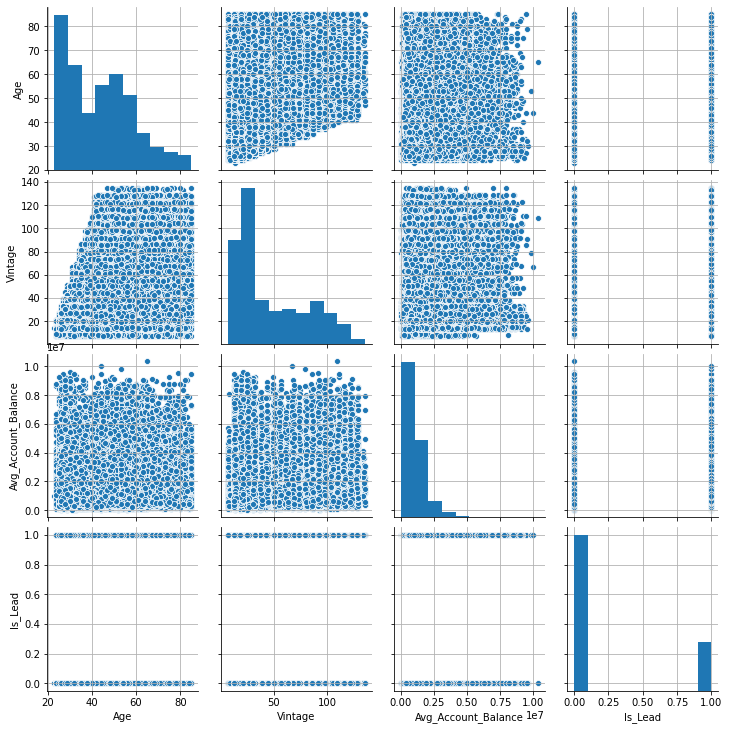

In [22]:
sns.pairplot(train.iloc[:,1:])

# Univariate Analysis

In [23]:
train['Is_Lead'].value_counts()

0    187437
1     58288
Name: Is_Lead, dtype: int64

Is_Lead(Target) :
    
If the Customer is interested for the Credit Card

0 : Customer is not interested

1 : Customer is interested

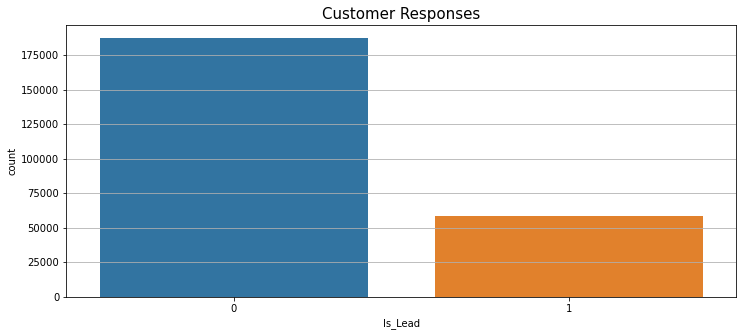

In [24]:
plt.figure(figsize=(12,5))
sns.countplot(train['Is_Lead'])
plt.title('Customer Responses', fontsize = 15)
plt.show()

In [25]:
#Calculating positive and negative samples in percentages

negative_response = (len(train[train.Is_Lead==0]))/len(train) * 100
print("Percent of Negative Response:",negative_response)

print()

positive_response = (len(train[train.Is_Lead==1]))/len(train) * 100
print("Percent of Positive Response:",positive_response)

Percent of Negative Response: 76.27917387323228

Percent of Positive Response: 23.720826126767726


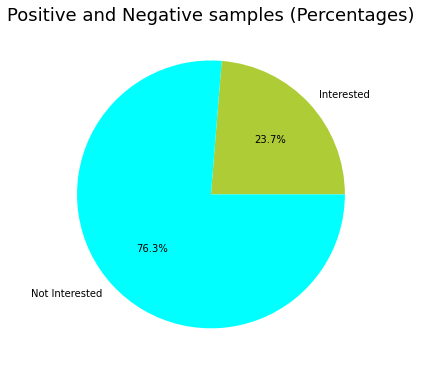

In [26]:
#Combined Response Percentage Values
percentages = [positive_response,negative_response]

# Creating a pie chart
plt.figure(figsize = (6,8))
plt.pie(percentages, labels=['Interested','Not Interested'], autopct = '%.1f%%', colors = ['#aecc35', 'cyan'])
plt.title('Positive and Negative samples (Percentages)', fontsize = 18)
plt.show()

This is a highly imbalanced dataset. 

The number of customers interested is only 23.7% whereas the number of customers not interested is 76.3%

In [27]:
interested_cust = train[train.Is_Lead == 1]
not_interested = train[train.Is_Lead == 0]

In [28]:
interested_cust.shape, not_interested.shape

((58288, 11), (187437, 11))

In [29]:
#Exploring Positive Response
interested_cust.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
6,ETQCZFEJ,Male,62,RG282,Other,X3,20,Yes,1056750,Yes,1
15,UJ2NJKKL,Male,33,RG268,Self_Employed,X2,69,Yes,517063,Yes,1
16,CNGSPYWS,Female,46,RG268,Other,X3,97,Yes,2282502,No,1
17,VH7NBNNQ,Female,59,RG283,Other,X3,15,Yes,2384692,No,1
20,7PMYNWB3,Male,44,RG269,Self_Employed,X2,19,Yes,1001650,No,1


# Analyzing Interested Customers

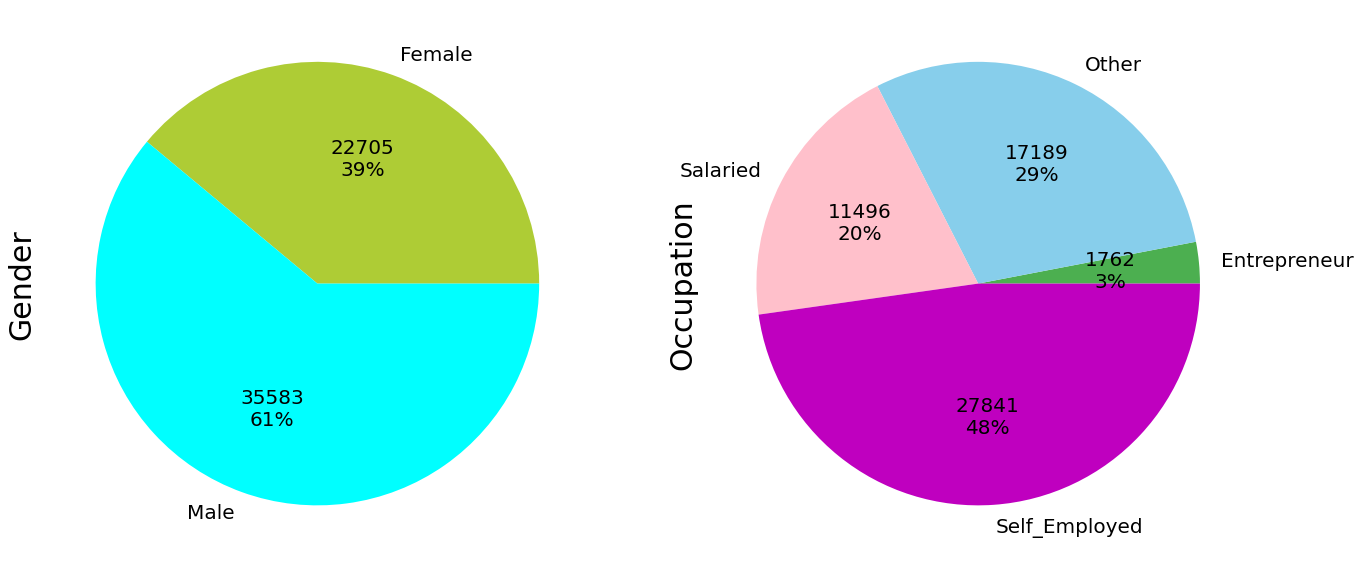

In [30]:
# Categorical Variables Pie Chart Analysis
# Gender and Occupation

def label_function(val):
    return f'{val / 100 * len(interested_cust):.0f}\n{val:.0f}%'


fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 8))

interested_cust.groupby('Gender').size().plot(kind='pie', autopct=label_function, textprops={'fontsize': 20},
                                  colors=['#aecc35', 'cyan'], ax=ax1)
interested_cust.groupby('Occupation').size().plot(kind='pie', autopct=label_function, textprops={'fontsize': 20},
                                 colors=['#4CAF50', 'skyblue', 'pink','m'], ax=ax2)

ax1.set_ylabel('Gender', size=30)
ax2.set_ylabel('Occupation', size=30)
plt.tight_layout()
plt.show()

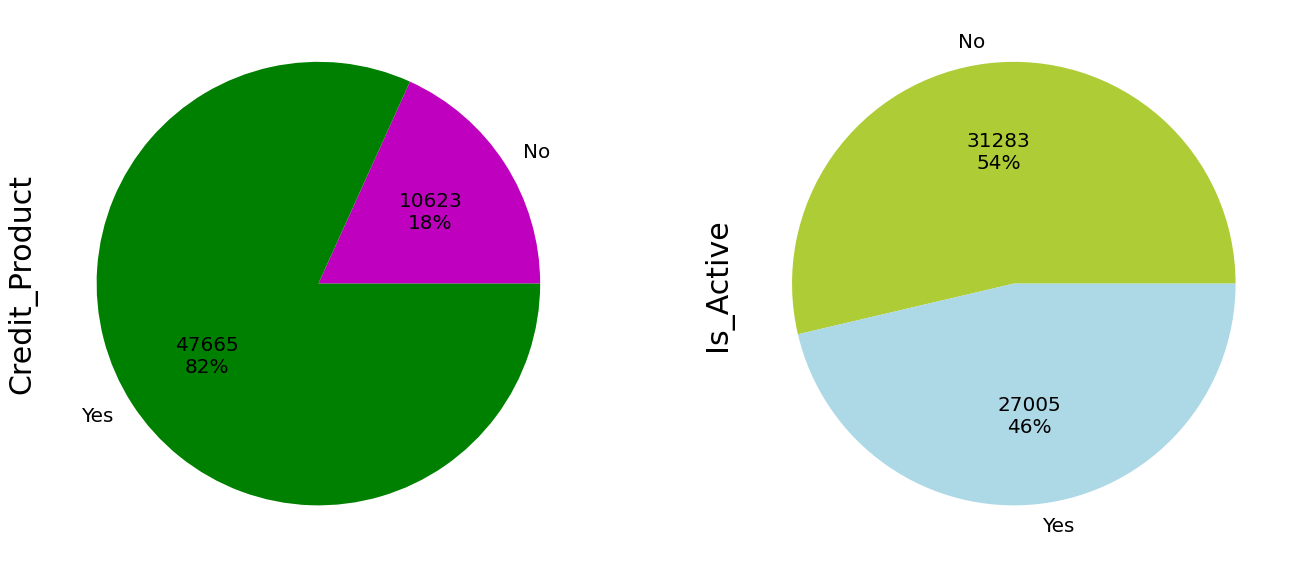

In [31]:
# Credit_Product and Active Customers

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 8))

interested_cust.groupby('Credit_Product').size().plot(kind='pie', autopct=label_function, textprops={'fontsize': 20},
                                 colors=['m', 'green'], ax=ax1)
interested_cust.groupby('Is_Active').size().plot(kind='pie', autopct=label_function, textprops={'fontsize': 20},
                                 colors=['#aecc35', 'lightblue'], ax=ax2)


ax1.set_ylabel('Credit_Product', size=30)
ax2.set_ylabel('Is_Active', size=30)
plt.tight_layout()
plt.show()

# Customer Age Profiling

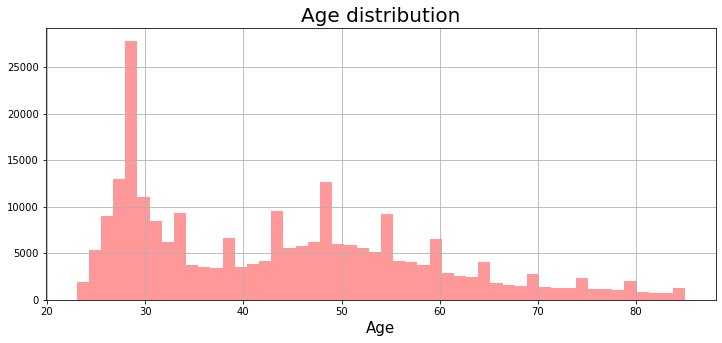

In [32]:
#Age Distribution of the train dataset
# Age of the Customer (in Years)

plt.figure(figsize = (12,5))
sns.distplot(train['Age'], kde = False, color = 'Red')
plt.xlabel('Age', fontsize = 15)
plt.title('Age distribution', fontsize = 20)
plt.show()

In [33]:
train['Age'].describe()

count    245725.000000
mean         43.856307
std          14.828672
min          23.000000
25%          30.000000
50%          43.000000
75%          54.000000
max          85.000000
Name: Age, dtype: float64

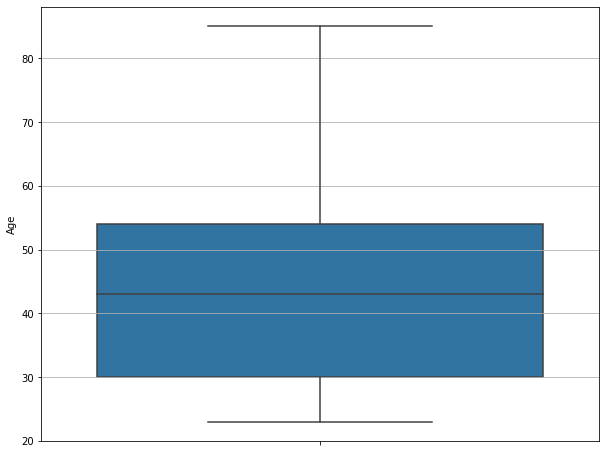

In [34]:
sns.boxplot(y = 'Age', data = train)

In [35]:
#Binning Age Variable
train['age_bin'] = pd.cut(train['Age'], bins = (20,35,45,55,65,75,85),
                          labels=['20-35', '36-45', '46-55','56-65','66-75','76-85'])

In [84]:
#Binning Age Variable
test['age_bin'] = pd.cut(test['Age'], bins = (20,35,45,55,65,75,85),
                          labels=['20-35', '36-45', '46-55','56-65','66-75','76-85'])

In [36]:
train['age_bin'].value_counts()

20-35    95807
46-55    56576
36-45    40239
56-65    30484
66-75    13802
76-85     8817
Name: age_bin, dtype: int64

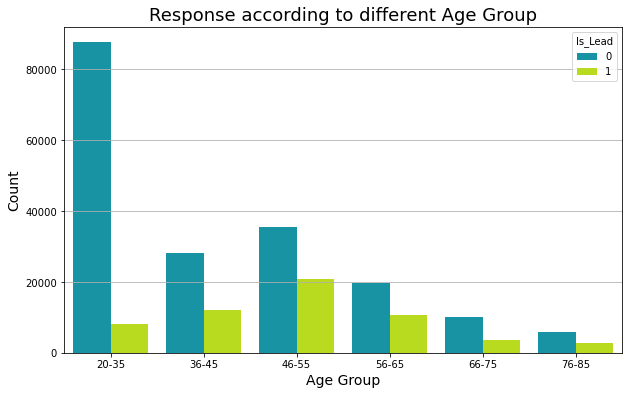

In [37]:
plt.figure(figsize = (10,6) )
sns.countplot(data = train, x = 'age_bin', hue = 'Is_Lead', palette = 'nipy_spectral')
plt.xlabel('Age Group', fontsize = 14)
plt.ylabel('Count', fontsize = 14)
plt.title('Response according to different Age Group', fontsize = 18)
plt.show()

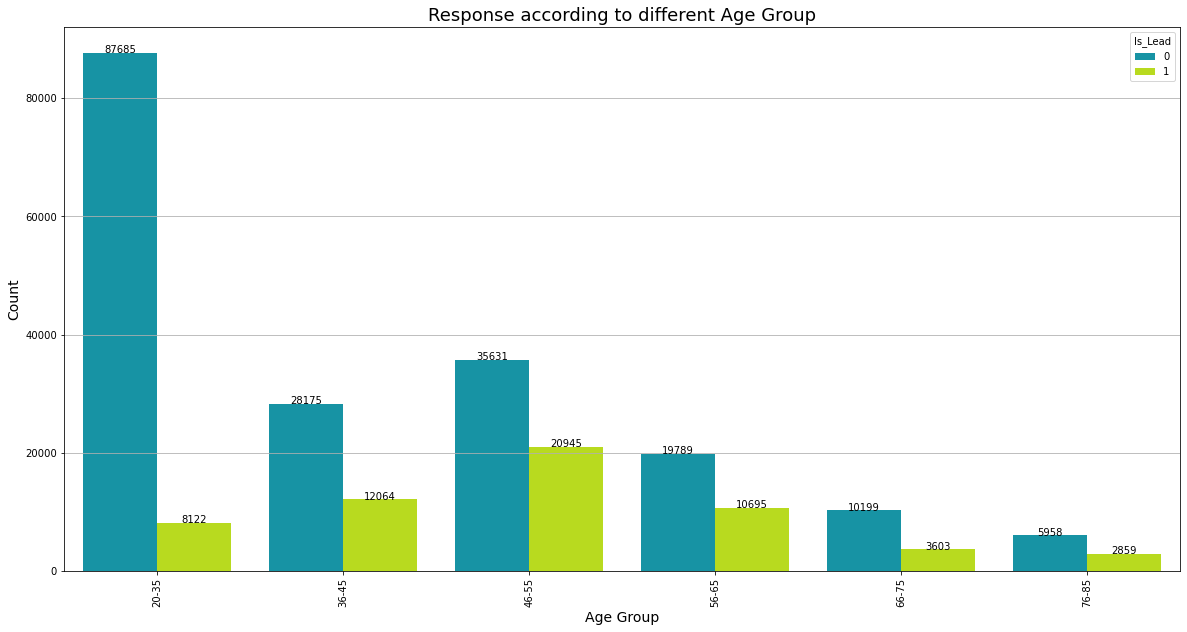

In [38]:
fig, ax1 = plt.subplots(figsize=(20,10))

graph = sns.countplot(ax=ax1, data = train, x = 'age_bin', hue = 'Is_Lead', palette = 'nipy_spectral')
graph.set_xticklabels(graph.get_xticklabels(),rotation=90)

for p in graph.patches:
    height = p.get_height()
    graph.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")

plt.xlabel('Age Group', fontsize = 14)
plt.ylabel('Count', fontsize = 14)
plt.title('Response according to different Age Group', fontsize = 18)
plt.show()




Insight:

The number of interested customer is maximum in the "46 to 55" age group. 

With increase in age, the number of interested customers gradually decreases.

# Vintage

In [39]:
# Vintage: Vintage for the Customer (In Months)
train['Vintage'].describe()

count    245725.000000
mean         46.959141
std          32.353136
min           7.000000
25%          20.000000
50%          32.000000
75%          73.000000
max         135.000000
Name: Vintage, dtype: float64

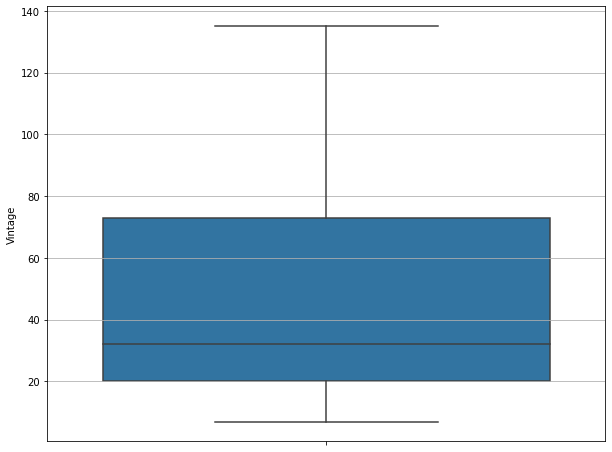

In [40]:
sns.boxplot(y = 'Vintage', data = train)

In [41]:
#Created new variable
#Converted number of months to duration of the customer (how old/new the customer is)

train['vintage_year']= (train['Vintage'])/12

In [42]:
#Binning Vintage Variable
train['vintage_bins'] = pd.cut(train['vintage_year'], bins = (0,2,4,6,8,10,12),
                      labels=['0-2', '2-4', '4-6','6-8','8-10','10-12'])

In [85]:
test['vintage_year']= (test['Vintage'])/12
test['vintage_bins'] = pd.cut(test['vintage_year'], bins = (0,2,4,6,8,10,12),
                      labels=['0-2', '2-4', '4-6','6-8','8-10','10-12'])

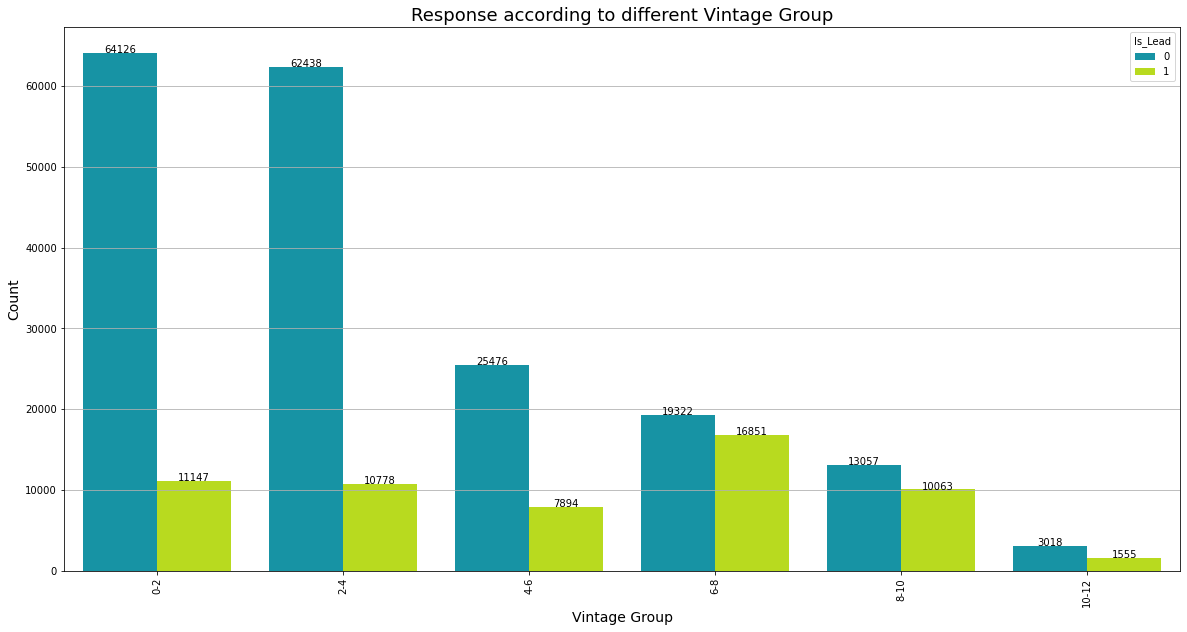

In [43]:
fig, ax1 = plt.subplots(figsize=(20,10))

graph = sns.countplot(ax=ax1, data = train, x = 'vintage_bins', hue = 'Is_Lead', palette = 'nipy_spectral')
graph.set_xticklabels(graph.get_xticklabels(),rotation=90)

for p in graph.patches:
    height = p.get_height()
    graph.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")

plt.xlabel('Vintage Group', fontsize = 14)
plt.ylabel('Count', fontsize = 14)
plt.title('Response according to different Vintage Group', fontsize = 18)
plt.show()

Insight: 

Vintage column has almost no correlation with Customer Response. 

That means a customer who is connected to the company for a long time doesn't necessarily mean that he/she will be interested in taking the credit card.

# Average Account Balance

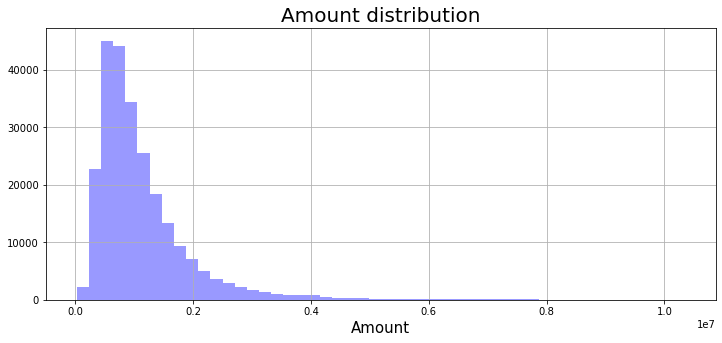

In [44]:
# Avearge Account Balance : Average Account Balance for the Customer in last 12 Months

plt.figure(figsize = (12,5))
sns.distplot(train['Avg_Account_Balance'], kde = False, color = 'Blue')
plt.xlabel('Amount', fontsize = 15)
plt.title('Amount distribution', fontsize = 20)
plt.show()

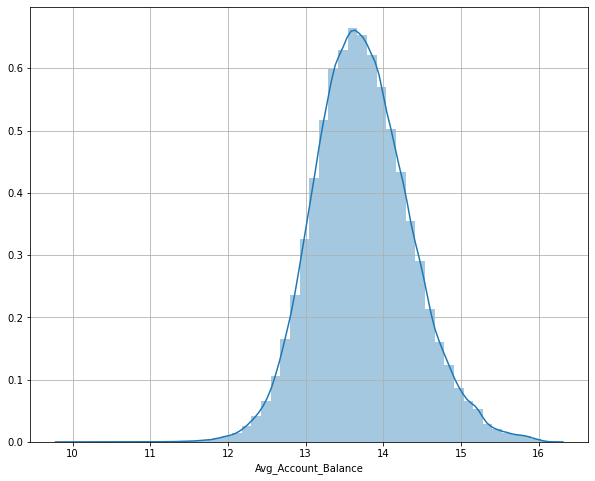

In [45]:
train['Avg_Account_Balance'] = np.log(train['Avg_Account_Balance'])
sns.distplot(train['Avg_Account_Balance'])
plt.show()

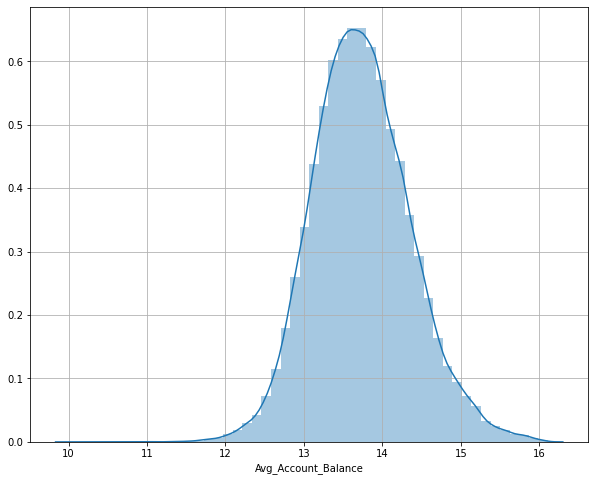

In [46]:
#Test Data
test['Avg_Account_Balance'] = np.log(test['Avg_Account_Balance'])
sns.distplot(test['Avg_Account_Balance'])
plt.show()

In [47]:
#Binning Age Variable
train['amount_bin'] = pd.qcut(train['Avg_Account_Balance'], q=[0, .2, .4, .6, .8, 1],
                          labels=['20K-100K', '100K-140K','140K-180K','180K-220K','220K-260K'])

In [86]:
test['amount_bin'] = pd.qcut(test['Avg_Account_Balance'], q=[0, .2, .4, .6, .8, 1],
                          labels=['20K-100K', '100K-140K','140K-180K','180K-220K','220K-260K'])

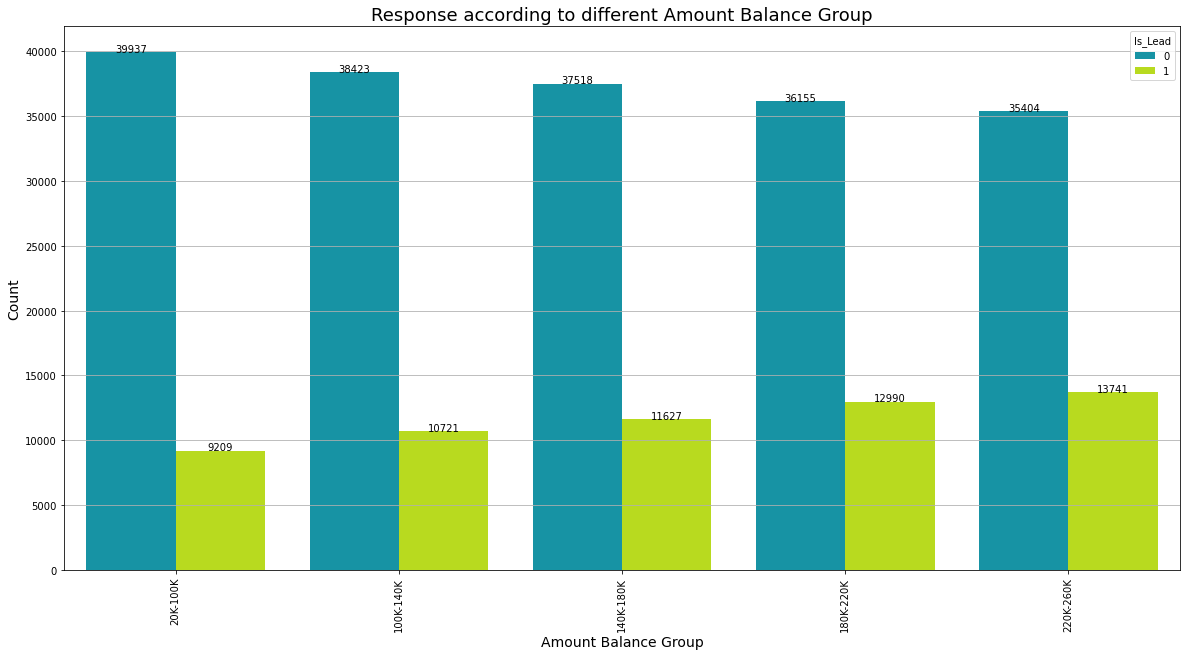

In [48]:
fig, ax1 = plt.subplots(figsize=(20,10))

graph = sns.countplot(ax=ax1, data = train, x = 'amount_bin', hue = 'Is_Lead', palette = 'nipy_spectral')
graph.set_xticklabels(graph.get_xticklabels(),rotation=90)

for p in graph.patches:
    height = p.get_height()
    graph.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")

plt.xlabel('Amount Balance Group', fontsize = 14)
plt.ylabel('Count', fontsize = 14)
plt.title('Response according to different Amount Balance Group', fontsize = 18)
plt.show()

Insight:
    
Customers showed more interest in credit card with increase in the average balance amount.

# Occupation

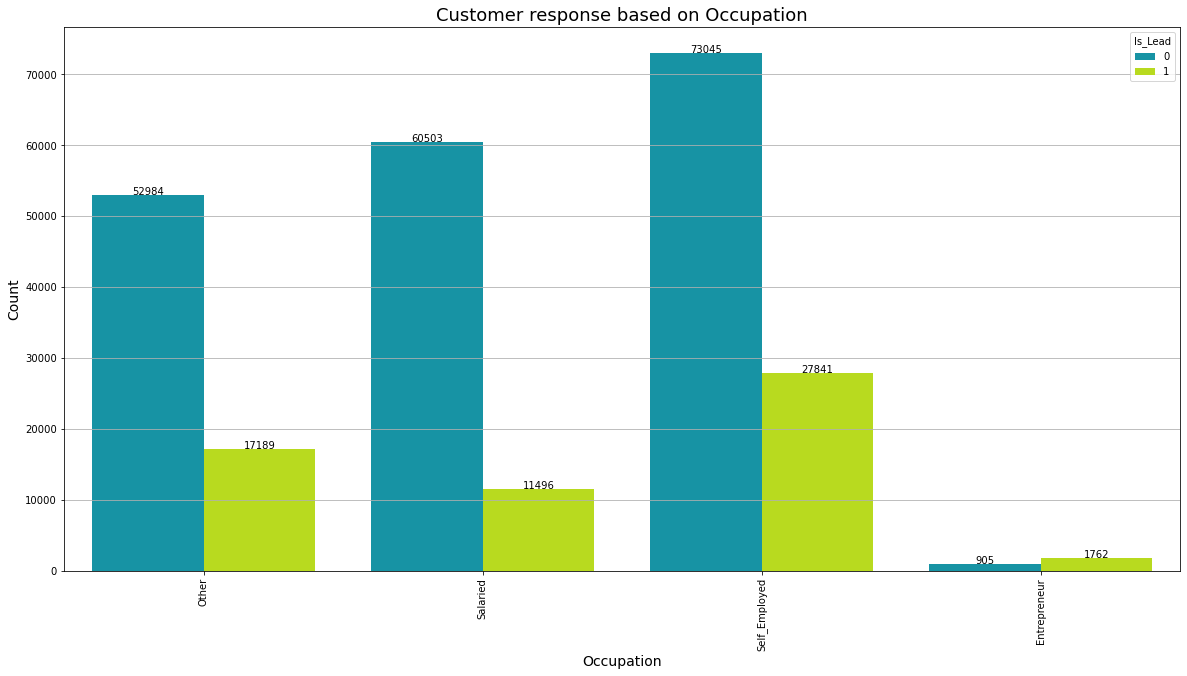

In [49]:
fig, ax1 = plt.subplots(figsize=(20,10))

graph = sns.countplot(ax=ax1, data = train, x = 'Occupation', hue = 'Is_Lead', palette = 'nipy_spectral')
graph.set_xticklabels(graph.get_xticklabels(),rotation=90)

for p in graph.patches:
    height = p.get_height()
    graph.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")

plt.xlabel('Occupation', fontsize = 14)
plt.ylabel('Count', fontsize = 14)
plt.title('Customer response based on Occupation', fontsize = 18)
plt.show()

Insight:
    
Self Employed, followed by Other and Salaried occupation groups showed more interest then Enterpreneurs. 

Most of the Enterpreneurs showed interest in Credit Card.

# Credit Product

If the Customer has any active credit product (Home loan,Personal loan, Credit Card etc.)

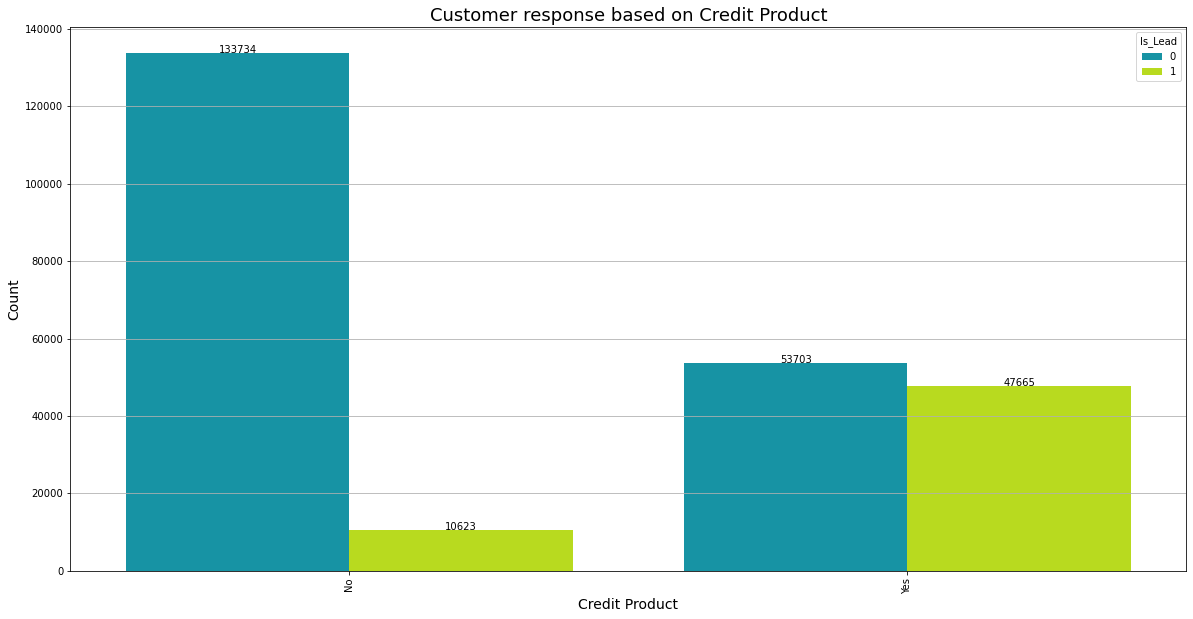

In [50]:
fig, ax1 = plt.subplots(figsize=(20,10))

graph = sns.countplot(ax=ax1, data = train, x = 'Credit_Product', hue = 'Is_Lead', palette = 'nipy_spectral')
graph.set_xticklabels(graph.get_xticklabels(),rotation=90)

for p in graph.patches:
    height = p.get_height()
    graph.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")

plt.xlabel('Credit Product', fontsize = 14)
plt.ylabel('Count', fontsize = 14)
plt.title('Customer response based on Credit Product', fontsize = 18)
plt.show()

Insight:

Customers with no active credit products have shown more interest in Credit Card than the customers with existing credit products.

# Active Customers

If the Customer is Active in last 3 Months

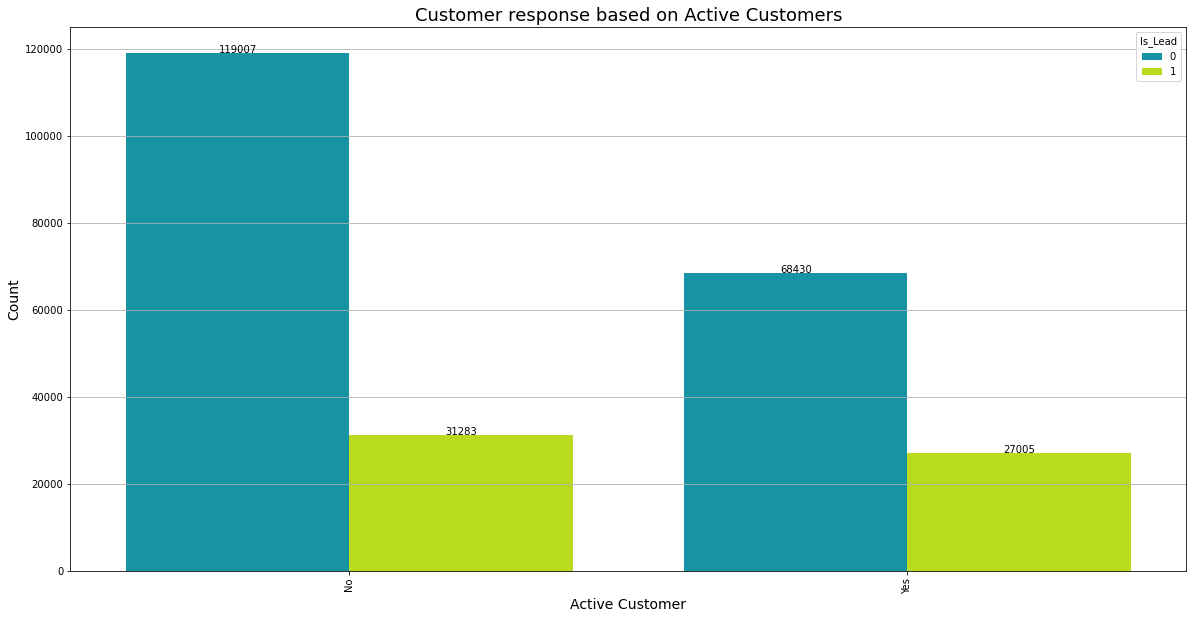

In [51]:
fig, ax1 = plt.subplots(figsize=(20,10))

graph = sns.countplot(ax=ax1, data = train, x = 'Is_Active', hue = 'Is_Lead', palette = 'nipy_spectral')
graph.set_xticklabels(graph.get_xticklabels(),rotation=90)

for p in graph.patches:
    height = p.get_height()
    graph.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")

plt.xlabel('Active Customer', fontsize = 14)
plt.ylabel('Count', fontsize = 14)
plt.title('Customer response based on Active Customers', fontsize = 18)
plt.show()

Insight:

Inactive Customers have shown more interest in Credit Card than the existing Active Customers.

# Gender Analysis

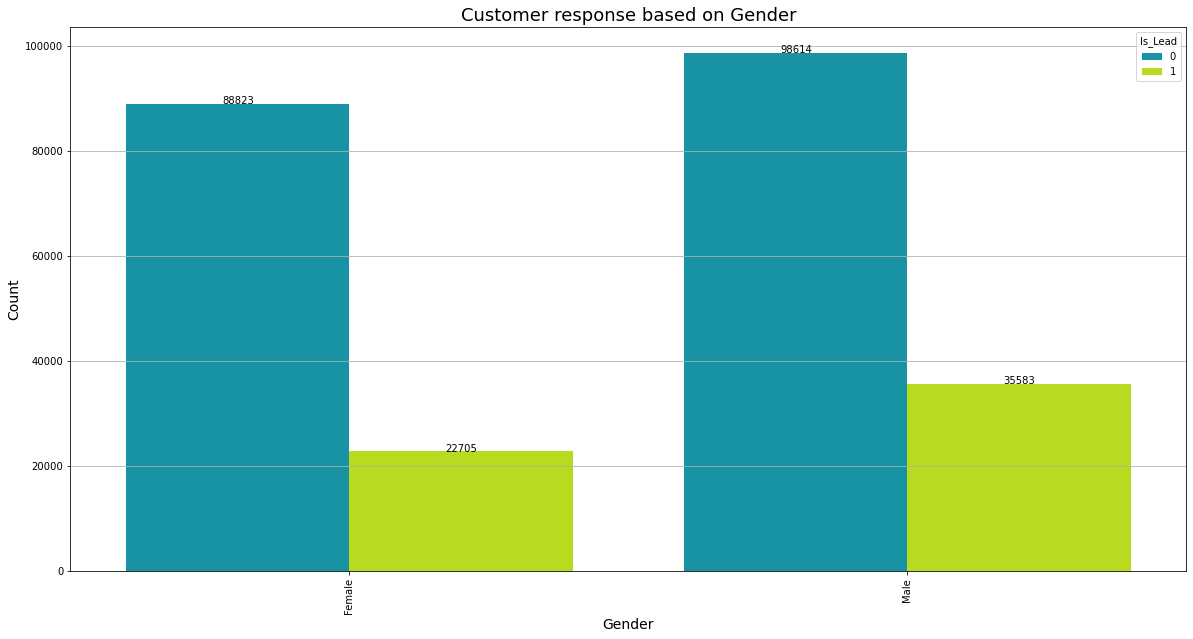

In [52]:
fig, ax1 = plt.subplots(figsize=(20,10))

graph = sns.countplot(ax=ax1, data = train, x = 'Gender', hue = 'Is_Lead', palette = 'nipy_spectral')
graph.set_xticklabels(graph.get_xticklabels(),rotation=90)

for p in graph.patches:
    height = p.get_height()
    graph.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")

plt.xlabel('Gender', fontsize = 14)
plt.ylabel('Count', fontsize = 14)
plt.title('Customer response based on Gender', fontsize = 18)
plt.show()

Insight:
    
Male Customers have shown more interest than Female customers.

# Region Code

Region Code: Code of the Region for the customers

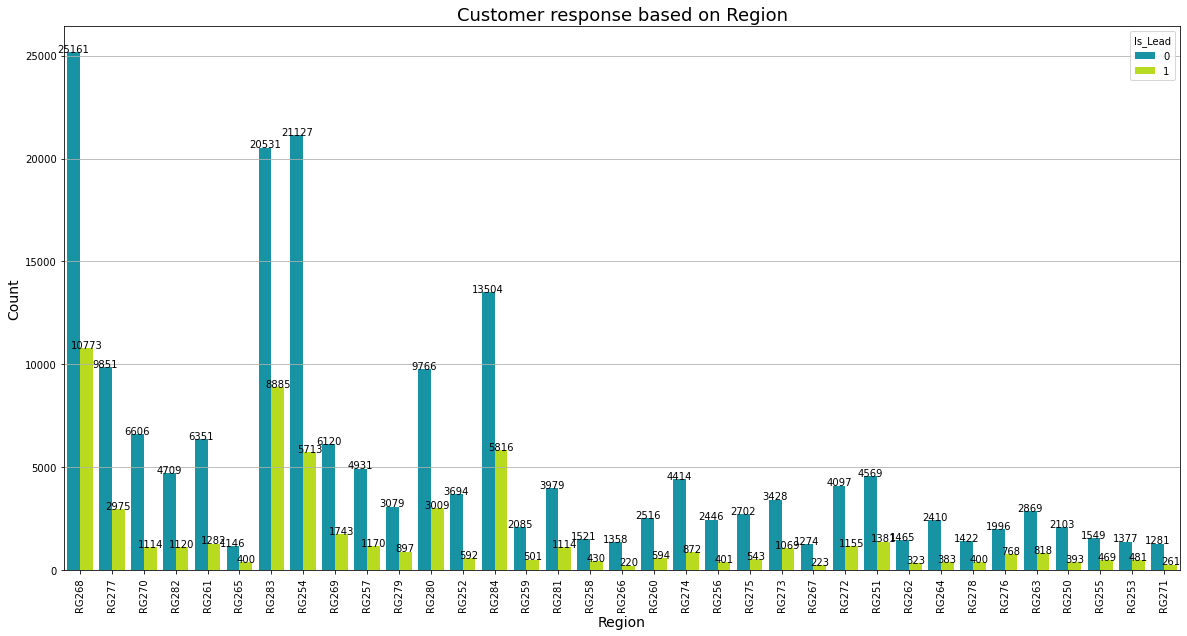

In [53]:
fig, ax1 = plt.subplots(figsize=(20,10))

graph = sns.countplot(ax=ax1, data = train, x = 'Region_Code', hue = 'Is_Lead', palette = 'nipy_spectral')
graph.set_xticklabels(graph.get_xticklabels(),rotation=90)

for p in graph.patches:
    height = p.get_height()
    graph.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")

plt.xlabel('Region', fontsize = 14)
plt.ylabel('Count', fontsize = 14)
plt.title('Customer response based on Region', fontsize = 18)
plt.show()

Top 5 Regions with highest interested customers:

1) RG268 - 10773

2) RG283 - 8885

3) RG284 - 5816

4) RG254 - 5713

5) RG280 - 3009

# Channel Code

Acquisition Channel Code for the Customer  (Encoded)

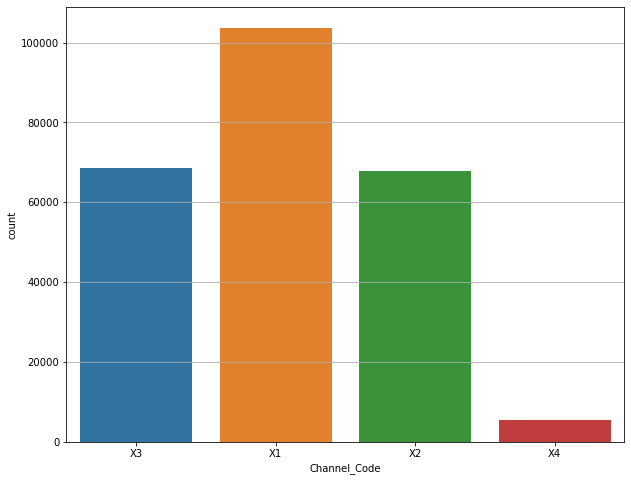

In [54]:
sns.countplot(train['Channel_Code'])

Most used channel is X1

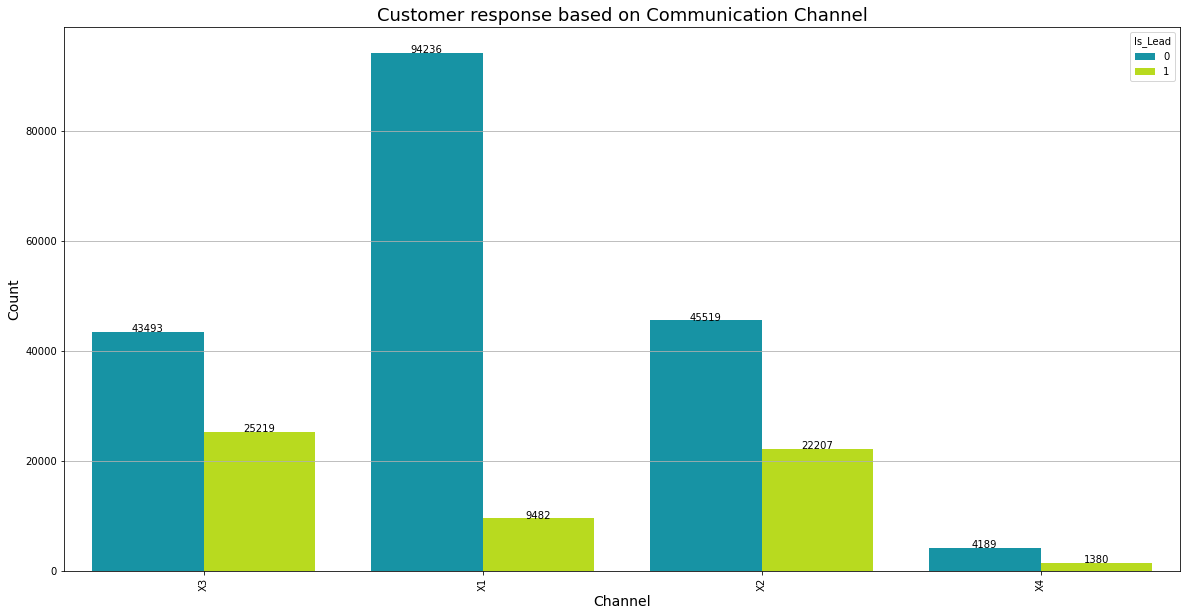

In [55]:
fig, ax1 = plt.subplots(figsize=(20,10))

graph = sns.countplot(ax=ax1, data = train, x = 'Channel_Code', hue = 'Is_Lead', palette = 'nipy_spectral')
graph.set_xticklabels(graph.get_xticklabels(),rotation=90)

for p in graph.patches:
    height = p.get_height()
    graph.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")

plt.xlabel('Channel', fontsize = 14)
plt.ylabel('Count', fontsize = 14)
plt.title('Customer response based on Communication Channel', fontsize = 18)
plt.show()

Insight:
    
Bank should communicate through X2 and X3 channels more, as these have maximum number of interested customers    

In [63]:
train.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead,age_bin,vintage_year,vintage_bins,amount_bin
0,NNVBBKZB,Female,73,RG268,Other,X3,43,No,13.860193,No,0,66-75,3.583333,2-4,140K-180K
1,IDD62UNG,Female,30,RG277,Salaried,X1,32,No,13.274205,No,0,20-35,2.666667,2-4,100K-140K
2,HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,No,14.210464,Yes,0,56-65,2.166667,2-4,180K-220K
3,BF3NC7KV,Male,34,RG270,Salaried,X1,19,No,13.061453,No,0,20-35,1.583333,0-2,20K-100K
4,TEASRWXV,Female,30,RG282,Salaried,X1,33,No,13.695360,No,0,20-35,2.750000,2-4,140K-180K


# Correlation heatmap

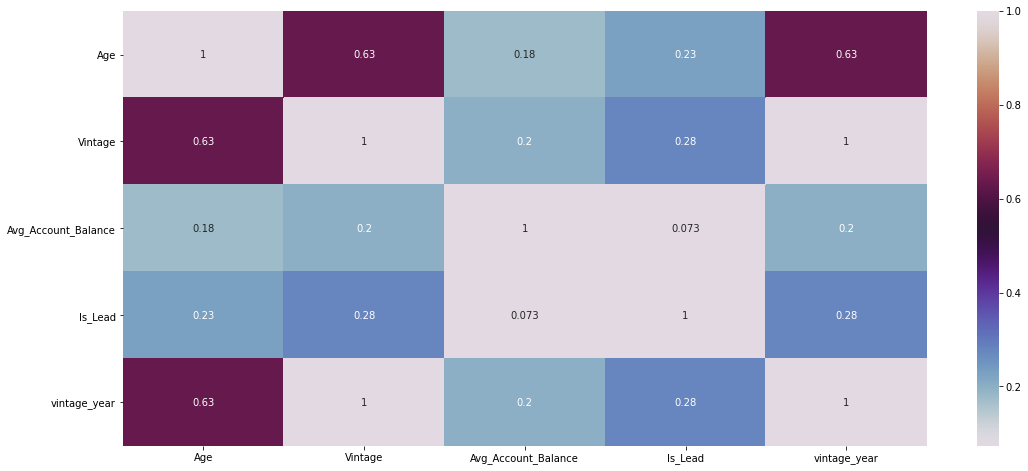

In [57]:
plt.figure(figsize = (18,8))
sns.heatmap(train.corr(), cmap = 'twilight', annot = True)
plt.show()

# Feature Engeneering

In [87]:
train_df = train.copy()
test_df = test.copy()

In [88]:
train_df.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead,age_bin,vintage_year,vintage_bins,amount_bin
0,NNVBBKZB,Female,73,RG268,Other,X3,43,No,13.860193,No,0,66-75,3.583333,2-4,140K-180K
1,IDD62UNG,Female,30,RG277,Salaried,X1,32,No,13.274205,No,0,20-35,2.666667,2-4,100K-140K
2,HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,No,14.210464,Yes,0,56-65,2.166667,2-4,180K-220K
3,BF3NC7KV,Male,34,RG270,Salaried,X1,19,No,13.061453,No,0,20-35,1.583333,0-2,20K-100K
4,TEASRWXV,Female,30,RG282,Salaried,X1,33,No,13.695360,No,0,20-35,2.750000,2-4,140K-180K


In [89]:
train_df.columns

Index(['ID', 'Gender', 'Age', 'Region_Code', 'Occupation', 'Channel_Code',
       'Vintage', 'Credit_Product', 'Avg_Account_Balance', 'Is_Active',
       'Is_Lead', 'age_bin', 'vintage_year', 'vintage_bins', 'amount_bin'],
      dtype='object')

In [90]:
#Dropping following variables
#train_df.drop([ 'age_bin', 'vintage_year', 'vintage_bins', 'amount_bin'], axis=1, inplace=True)

In [91]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 245725 entries, 0 to 245724
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   ID                   245725 non-null  object  
 1   Gender               245725 non-null  object  
 2   Age                  245725 non-null  int64   
 3   Region_Code          245725 non-null  object  
 4   Occupation           245725 non-null  object  
 5   Channel_Code         245725 non-null  object  
 6   Vintage              245725 non-null  int64   
 7   Credit_Product       245725 non-null  object  
 8   Avg_Account_Balance  245725 non-null  float64 
 9   Is_Active            245725 non-null  object  
 10  Is_Lead              245725 non-null  int64   
 11  age_bin              245725 non-null  category
 12  vintage_year         245725 non-null  float64 
 13  vintage_bins         245725 non-null  category
 14  amount_bin           245725 non-null  category
dtype

# Label Encoding

In [92]:
train_df.drop('ID',axis=1,inplace=True)
test_df.drop("ID",axis=1,inplace = True)

In [93]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

var_mod = ['Gender','Region_Code','Occupation','Channel_Code','Credit_Product','Is_Active','age_bin', 'vintage_year', 'vintage_bins', 'amount_bin']

for i in var_mod:
    train_df[i] = le.fit_transform(train_df[i])
    test_df[i] = le.fit_transform(test_df[i])

In [94]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 245725 entries, 0 to 245724
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Gender               245725 non-null  int32  
 1   Age                  245725 non-null  int64  
 2   Region_Code          245725 non-null  int32  
 3   Occupation           245725 non-null  int32  
 4   Channel_Code         245725 non-null  int32  
 5   Vintage              245725 non-null  int64  
 6   Credit_Product       245725 non-null  int32  
 7   Avg_Account_Balance  245725 non-null  float64
 8   Is_Active            245725 non-null  int32  
 9   Is_Lead              245725 non-null  int64  
 10  age_bin              245725 non-null  int32  
 11  vintage_year         245725 non-null  int64  
 12  vintage_bins         245725 non-null  int32  
 13  amount_bin           245725 non-null  int32  
dtypes: float64(1), int32(9), int64(4)
memory usage: 29.7 MB


In [95]:
# converting the float variables to int because cat boost dosen't take float for categorical variables 
train_df['Avg_Account_Balance'] = train_df['Avg_Account_Balance'].astype(int)
test_df['Avg_Account_Balance'] = test_df['Avg_Account_Balance'].astype(int)

In [96]:
train_df['Is_Lead'] = train_df['Is_Lead'].astype(int)  # Converting object to int
train_df.shape ,test_df.shape

((245725, 14), (105312, 13))

In [97]:
X = train_df.drop('Is_Lead',axis=1)
y = train_df['Is_Lead']

# Stratified K Fold

In [98]:

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score

def cross_val(X, y, model, params, folds=9):

    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=21)
    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        print(f"Fold: {fold}")
        x_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        x_test, y_test = X.iloc[test_idx], y.iloc[test_idx]

        alg = model(**params)
        alg.fit(x_train, y_train,
                eval_set=[(x_test, y_test)],
                early_stopping_rounds=100,
                verbose=400)

        pred = alg.predict_proba(x_test)[:, 1]
        roc_score = roc_auc_score(y_test, pred)
        print(f"roc_auc_score: {roc_score}")
        print("-"*50)
    
    return alg

# Light GBM

In [99]:
lgb_params= {'learning_rate': 0.045, 
             'n_estimators': 20000, 
             'max_bin': 94,
             'num_leaves': 10, 
             'max_depth': 27, 
             'reg_alpha': 8.457, 
             'reg_lambda': 6.853, 
             'subsample': 0.749}

In [100]:
from lightgbm import LGBMClassifier
lgb_model = cross_val(X, y, LGBMClassifier, lgb_params)

Fold: 0
Training until validation scores don't improve for 100 rounds
[400]	valid_0's binary_logloss: 0.378576
Early stopping, best iteration is:
[512]	valid_0's binary_logloss: 0.378421
roc_auc_score: 0.8538397019204029
--------------------------------------------------
Fold: 1
Training until validation scores don't improve for 100 rounds
[400]	valid_0's binary_logloss: 0.382507
[800]	valid_0's binary_logloss: 0.38239
Early stopping, best iteration is:
[776]	valid_0's binary_logloss: 0.382378
roc_auc_score: 0.8501886166971041
--------------------------------------------------
Fold: 2
Training until validation scores don't improve for 100 rounds
[400]	valid_0's binary_logloss: 0.384531
Early stopping, best iteration is:
[595]	valid_0's binary_logloss: 0.384461
roc_auc_score: 0.8474087413494023
--------------------------------------------------
Fold: 3
Training until validation scores don't improve for 100 rounds
[400]	valid_0's binary_logloss: 0.383296
Early stopping, best iteration is

# XG Boost

In [101]:
xgb_params= {'n_estimators': 20000, 
             'max_depth': 6, 
             'learning_rate': 0.0201, 
             'reg_lambda': 29.326, 
             'subsample': 0.818, 
             'colsample_bytree': 0.235, 
             'colsample_bynode': 0.820, 
             'colsample_bylevel': 0.453}

In [102]:
from xgboost import XGBClassifier
xgb_model = cross_val(X, y, XGBClassifier, xgb_params)

Fold: 0
[0]	validation_0-error:0.20774
Will train until validation_0-error hasn't improved in 100 rounds.
Stopping. Best iteration:
[0]	validation_0-error:0.20774

roc_auc_score: 0.7764552678492335
--------------------------------------------------
Fold: 1
[0]	validation_0-error:0.21236
Will train until validation_0-error hasn't improved in 100 rounds.
Stopping. Best iteration:
[0]	validation_0-error:0.21236

roc_auc_score: 0.7742143778478268
--------------------------------------------------
Fold: 2
[0]	validation_0-error:0.21038
Will train until validation_0-error hasn't improved in 100 rounds.
Stopping. Best iteration:
[0]	validation_0-error:0.21038

roc_auc_score: 0.7751580248153316
--------------------------------------------------
Fold: 3
[0]	validation_0-error:0.21166
Will train until validation_0-error hasn't improved in 100 rounds.
Stopping. Best iteration:
[0]	validation_0-error:0.21166

roc_auc_score: 0.7785241896578814
--------------------------------------------------
Fold

# CatBoost

In [103]:
cat_params= {'n_estimators': 20000, 
                  'depth': 4, 
                  'learning_rate': 0.023, 
                  'colsample_bylevel': 0.655, 
                  'bagging_temperature': 0.921, 
                  'l2_leaf_reg': 10.133}

In [104]:
from catboost import CatBoostClassifier
cat_model = cross_val(X, y, CatBoostClassifier, cat_params)

Fold: 0
0:	learn: 0.6764919	test: 0.6764198	best: 0.6764198 (0)	total: 76.4ms	remaining: 25m 28s
400:	learn: 0.3838865	test: 0.3809052	best: 0.3809052 (400)	total: 32.5s	remaining: 26m 29s
800:	learn: 0.3816247	test: 0.3792325	best: 0.3792325 (800)	total: 1m 10s	remaining: 28m 20s
1200:	learn: 0.3805742	test: 0.3788512	best: 0.3788475 (1185)	total: 1m 50s	remaining: 28m 55s
1600:	learn: 0.3798182	test: 0.3787307	best: 0.3787307 (1600)	total: 2m 24s	remaining: 27m 44s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.3786936867
bestIteration = 1715

Shrink model to first 1716 iterations.
roc_auc_score: 0.8535533307375598
--------------------------------------------------
Fold: 1
0:	learn: 0.6764519	test: 0.6764361	best: 0.6764361 (0)	total: 95.1ms	remaining: 31m 41s
400:	learn: 0.3834936	test: 0.3847020	best: 0.3847020 (400)	total: 34.6s	remaining: 28m 12s
800:	learn: 0.3811628	test: 0.3832297	best: 0.3832297 (800)	total: 1m 13s	remaining: 29m 26s
1200:	learn: 0.38009

In [105]:
pred_test_lgb = lgb_model.predict_proba(test_df)[:,1]
pred_test_xgb = xgb_model.predict_proba(test_df)[:,1]
pred_test_cat = cat_model.predict_proba(test_df)[:,1]

#prediction = (pred_test_lgb + pred_test_cat+pred_test_xgb)/3

In [106]:
# submitting our predictions
ensembled_prediction = (0.5*pred_test_lgb)+(0.5*pred_test_cat)
ensembled_prediction

array([0.07121516, 0.36495564, 0.057419  , ..., 0.08035045, 0.22990677,
       0.05384415])

In [107]:

sample_submission['Is_Lead'] = ensembled_prediction
sample_submission.to_csv(f'submission.csv',index=False)

In [108]:
sample_submission['Is_Lead'] = pred_test_lgb
sample_submission.to_csv(f'pred_test_lgb.csv',index=False)

sample_submission['Is_Lead'] = pred_test_xgb
sample_submission.to_csv(f'pred_test_xgb.csv',index=False)

sample_submission['Is_Lead'] = pred_test_cat
sample_submission.to_csv(f'pred_test_cat.csv',index=False)

# Feature importance

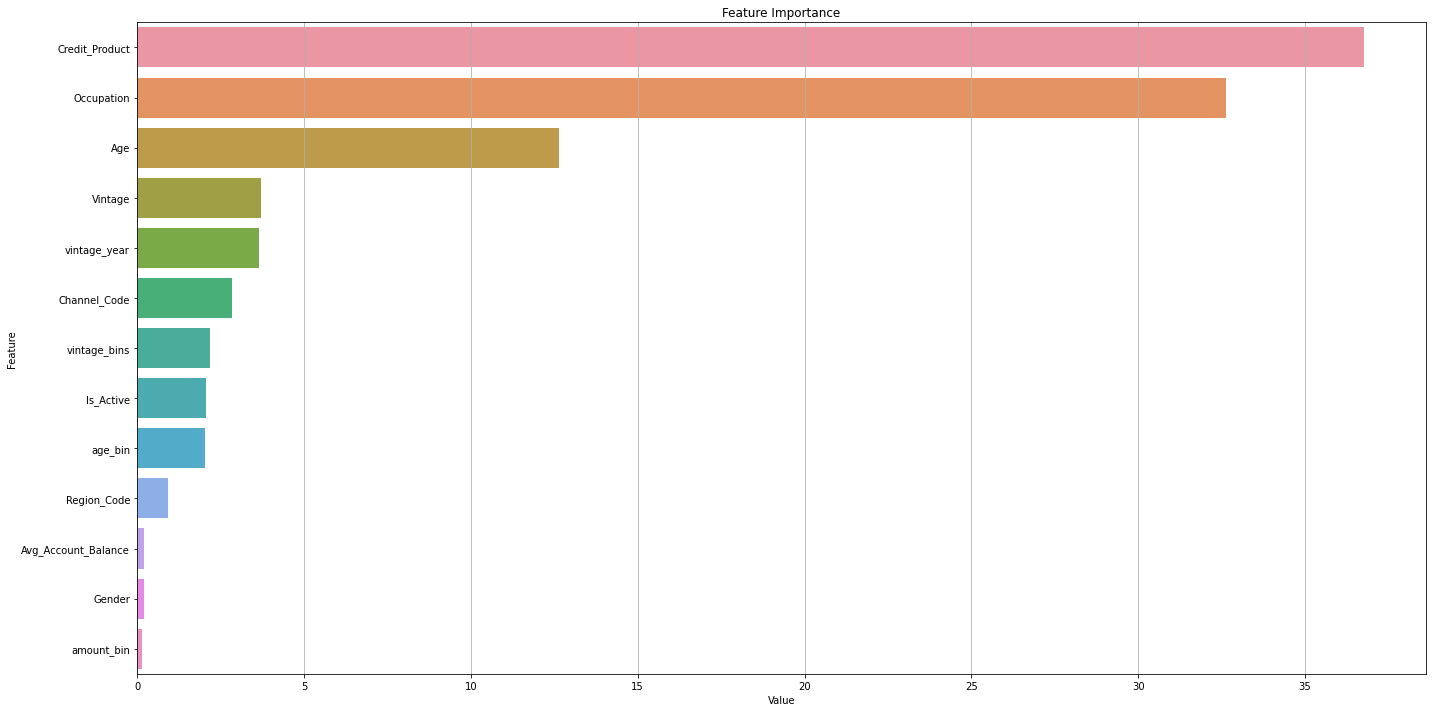

In [109]:
feature_imp = pd.DataFrame(sorted(zip(cat_model.feature_importances_,X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('Feature Importance')
plt.tight_layout()
plt.show()